# Fáza 3 - Strojové učenie

In [61]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, FunctionTransformer, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier


In [62]:
connections = pd.read_csv('data/connections.csv', sep='\t')
connections['ts'] = pd.to_datetime(connections['ts'])

processes = pd.read_csv('data/processes.csv', sep='\t')
processes['ts'] = pd.to_datetime(processes['ts'])

conn_processes = pd.merge(connections, processes, on=['ts', 'imei', 'mwra'], how='inner')
conn_processes.drop_duplicates(inplace=True)

Načítanie a spojenie datasetov connections a processes ako v minulej fáze projektu.

In [63]:
X = conn_processes.drop(columns=['mwra'])
y = conn_processes['mwra'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Rozdelenie spojeného datasetu na trénovaciu a testovaciu sadu.

In [64]:
def encode_values(df):
    df['ts'] = df['ts'].astype('int64')
    return df

def remove_attributes(df):
    df = df.drop(['ts', 'imei'], axis=1)
    return df

def fill_missing_values(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        df[col] = df[col].fillna(df[col].median())

    return df

def outlier_replacement(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        lower_bound = df[col].quantile(0.05)
        upper_bound = df[col].quantile(0.95)

        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    
    return df

Funkcie na kódovanie atribútov, odstránenie atribútov, vyplnenia chýbajúcich hodnôt a nahradenia vychýlených hodnôt.

In [65]:
X_train_original = remove_attributes(encode_values(X_train)).to_numpy()
X_test_original = remove_attributes(encode_values(X_test)).to_numpy()

Ponechanie originálnych súborov bez transformácie v tvare numpy array.

In [66]:
encoder_transformer = FunctionTransformer(func=encode_values, validate=False)
removal_transformer = FunctionTransformer(func=remove_attributes, validate=False)
inputer_transformer = FunctionTransformer(func=fill_missing_values, validate=False)
outliers_transformer = FunctionTransformer(func=outlier_replacement, validate=False)

In [67]:
standard_columns = ['c.UCMobile.intl', 'c.updateassist', 'c.UCMobile.x86', 'p.android.defcontainer', 'p.google', 'p.android.gms', 'p.olauncher', 'p.android.vending', 'p.browser.provider', 'p.process.gapps', 'p.gms.persistent', 'p.simulator']
minmax_columns = ['p.android.chrome', 'p.android.documentsui', 'p.android.gm']
power_columns = ['p.notifier']
quantile_columns = ['c.android.gm', 'c.android.youtube', 'c.katana', 'c.dogalize', 'c.android.chrome', 'c.android.vending', 'c.raider', 'p.system', 'p.android.externalstorage', 'p.android.packageinstaller', 'p.android.settings', 'p.inputmethod.latin', 'p.katana', 'p.dogalize']

In [68]:
preprocessor = ColumnTransformer(
    transformers=[
        ('standard', StandardScaler(), standard_columns),
        ('minmax', MinMaxScaler(), minmax_columns),
        ('power', PowerTransformer(method='yeo-johnson'), power_columns),
        ('quantile', QuantileTransformer(output_distribution='normal'), quantile_columns)
    ],
    remainder='passthrough'
)

Preprocessor na transformáciu všetkých atribútov pomocou zvolených metód.

In [69]:
pipeline = Pipeline(steps=[
    ('encoding', encoder_transformer),
    ('removing', removal_transformer),
    ('outliers', outliers_transformer),
    ('inputer', inputer_transformer),
    ('preprocessor', preprocessor)
])

In [70]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

Pipeline na predspracovanie údajov pre strojové učenie.

### 3.1 Jednoduchý klasifikátor na základe závislosti v dátach

### (A)

Dáta sme sa rozhodli ešte raz pretransformovať pomocou **KBinsDiscretizer**, nakoľko **ID3 klasifikátor** je nevrhnutý tak, aby pracoval s kategorickými dátami. Keďže náš súbor obsahoval iba numerické dáta, táto transformácia zaručí, že jednotlivé hodnoty budú rozdelené do menšieho počtu skupín. Zvolili sme si 5 skupín a rozdelenie uniform, čo znamená že každá skupina bude mať rovnako veľký rozsah.

In [71]:
discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')

X_train_binned = discretizer.fit_transform(X_train_transformed)
X_test_binned = discretizer.transform(X_test_transformed)

##### Klasifikátor
ID3 klasifikátor sme implementovali pomocou triedy s nastaviteľnou maximálnou hĺbkou. Bližšie vysvetlenie ako klasifikátor funguje sa nachádza v komentároch v kóde.

In [72]:
class ID3Classifier:
    def __init__(self, max_depth): # inicializacia stromu s maximalnou hlbkou
        self.max_depth = max_depth
        self.tree = None

    def calculate_entropy(self, y): # vypocet entropie
        _, counts = np.unique(y, return_counts=True) # unikatne hodnoty
        probabilities = counts / len(y)
        
        return -np.sum(probabilities * np.log2(probabilities)) # vzorec na vypocet entropie

    def calculate_information_gain(self, X, y, threshold): # vypocet information gain
        left_mask = X <= threshold # rozdeli, ktore prvky pojdu do lavej a pravej vetvy
        right_mask = ~left_mask
        
        if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
            return 0

        entropy = self.calculate_entropy(y)
        n_left, n_right = np.sum(left_mask), np.sum(right_mask)

        # vzorec na vypocet vazenej entropie (child entropy)
        weighted_entropy = (n_left / len(y)) * self.calculate_entropy(y[left_mask]) + (n_right / len(y)) * self.calculate_entropy(y[right_mask])

        return entropy - weighted_entropy

    def get_best_split(self, X, y): # najde najlepsie miesto na rozdelenie dat
        best_col = None
        best_threshold = None
        best_gain = -1

        for col in range(X.shape[1]): # iteracia cez vsetky atributy
            thresholds = np.unique(X[:, col]) # unikatne hodnoty ako potencialne trasholds
            
            for tr in thresholds:
                gain = self.calculate_information_gain(X[:, col], y, tr)
                
                if gain > best_gain: # priradenie podla najvacsej hodnoty information gain
                    best_col = col
                    best_threshold = tr
                    best_gain = gain

        return best_col, best_threshold

    def get_most_common_class(self, y): # vrati triedu s najvacsim vyskytom
        unique, counts = np.unique(y, return_counts=True)
        return unique[np.argmax(counts)]

    def build_tree(self, X, y, depth): # funkcia na vytvorenie decision tree
        if depth == self.max_depth or len(np.unique(y)) == 1:
            return self.get_most_common_class(y) # zastavenie rozdelenia

        col, threshold = self.get_best_split(X, y)
        
        if col is None:
            return self.get_most_common_class(y)

        left_mask = X[:, col] <= threshold # rozdelenie dat podla trasholdu
        right_mask = ~left_mask

        return { # vytvori novy node a rekurzivne lavu a pravu stranu
            'feature': col,
            'threshold': threshold,
            'left': self.build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self.build_tree(X[right_mask], y[right_mask], depth + 1),
        }

    def fit(self, X, y): # trenovanie decision tree na zvolenych datach
        self.tree = self.build_tree(X, y, 0)

    def predict_sample(self, sample, tree): # predpoved triedy pre jednu vzorku
        if not isinstance(tree, dict): # ukoncenie ak ide o list
            return tree
        if sample[tree['feature']] <= tree['threshold']: # rozhodnutie ci pokracovat v lavej alebo pravej vetve
            return self.predict_sample(sample, tree['left'])
        else:
            return self.predict_sample(sample, tree['right'])

    def predict(self, X): # predpoved triedy pre vsetky vzorky
        return np.array([self.predict_sample(x, self.tree) for x in X])

Klasifikátor sme implementovali pre maximálnu hĺbku 2 a 5 aby sme videli ako sa menia výsledky s rôznymi hodnotami.

In [73]:
classifier_2 = ID3Classifier(2)

classifier_2.fit(X_train_binned, y_train)
predictions_2 = classifier_2.predict(X_test_binned)

classifier_5 = ID3Classifier(5)

classifier_5.fit(X_train_binned, y_train)
predictions_5 = classifier_5.predict(X_test_binned)

### (B)

In [74]:
def get_id3_results(predictions, depth):
    print(f'\nID3 Classifier results (depth: {depth})')
    
    print('Accuracy:', accuracy_score(y_test, predictions))
    print('Precision:', precision_score(y_test, predictions))
    print('Recall:', recall_score(y_test, predictions))

get_id3_results(predictions_2, 2)
get_id3_results(predictions_5, 5)


ID3 Classifier results (depth: 2)
Accuracy: 0.8024032042723631
Precision: 0.7837116154873164
Recall: 0.9432244242099626

ID3 Classifier results (depth: 5)
Accuracy: 0.8584779706275033
Precision: 0.8528117359413203
Recall: 0.9341189073379753


Výsledky znázorňujú, že klasifikátor s hĺbkou 5 je lepší čo sa týka *accuracy* a *precision*, ale je mierne horší pri *recall*. To znamená, že nemusí byť až tak efektívny pri identifikácii všetkých pozitívnych prípadov. Keďže robíme všeobecnú predikciu, budeme v tomto prípade považovať model s hĺbkou 5 ako efektívnejší. 

### (C)

In [75]:
predictions_5_train = classifier_5.predict(X_train_binned)

print('Training Accuracy:', accuracy_score(y_train, predictions_5_train))
print('Training Precision:', precision_score(y_train, predictions_5_train))
print('Training Recall:', recall_score(y_train, predictions_5_train))

print('\nTest Accuracy:', accuracy_score(y_test, predictions_5))
print('Test Precision:', precision_score(y_test, predictions_5))
print('Test Recall:', recall_score(y_test, predictions_5))

Training Accuracy: 0.8576435246995995
Training Precision: 0.8499337588823317
Training Recall: 0.9388053744845017

Test Accuracy: 0.8584779706275033
Test Precision: 0.8528117359413203
Test Recall: 0.9341189073379753


Klasifikátor nemá overfit. Hodnoty všetkých troch metrík sú veľmi podobné pri predikciách na trénovacích aj testovacích dátach. To naznačuje, že model dobre generalizuje a je schopný správne fungovať aj pri nových dátach.

### 3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia

### (A)

In [76]:
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train_transformed, y_train)
dt_predictions = dt_model.predict(X_test_transformed)

### (B)

In [77]:
lr_model = LogisticRegression(max_iter=500, random_state=42)
lr_model.fit(X_train_transformed, y_train)
lr_predictions = lr_model.predict(X_test_transformed)

In [78]:
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_precision = precision_score(y_test, dt_predictions, average='weighted')
dt_recall = recall_score(y_test, dt_predictions, average='weighted')

lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions, average='weighted')
lr_recall = recall_score(y_test, lr_predictions, average='weighted')

print("Výsledky Decision Tree:")
print(f"Accuracy: {dt_accuracy:.4f}, Precision: {dt_precision:.4f}, Recall: {dt_recall:.4f}")
print("\nVýsledky Logistic Regression:")
print(f"Accuracy: {lr_accuracy:.4f}, Precision: {lr_precision:.4f}, Recall: {lr_recall:.4f}")

Výsledky Decision Tree:
Accuracy: 0.8788, Precision: 0.8783, Recall: 0.8788

Výsledky Logistic Regression:
Accuracy: 0.8919, Precision: 0.8919, Recall: 0.8919


### (C)

In [79]:
id3_accuracy = accuracy_score(y_test, predictions_5)
id3_precision = precision_score(y_test, predictions_5, average='weighted')
id3_recall = recall_score(y_test, predictions_5, average='weighted')

print("Výsledky ID3 Classifier:")
print(f"Accuracy: {id3_accuracy:.4f}, Precision: {id3_precision:.4f}, Recall: {id3_recall:.4f}")

Výsledky ID3 Classifier:
Accuracy: 0.8585, Precision: 0.8595, Recall: 0.8585


In [80]:
results = pd.DataFrame({
    'Model': ['Decision Tree', 'Logictic Regresion', 'ID3 Classifier'],
    'Accuracy': [dt_accuracy, lr_accuracy, id3_accuracy],
    'Precision': [dt_precision, lr_precision, id3_precision],
    'Recall': [dt_recall, lr_recall, id3_recall]
})

results.set_index('Model', inplace=True)
results

,Accuracy,Precision,Recall
Model,,,
Decision Tree,0.878838,0.878309,0.878838
Logictic Regresion,0.891856,0.891941,0.891856
ID3 Classifier,0.858478,0.859539,0.858478


### (D)

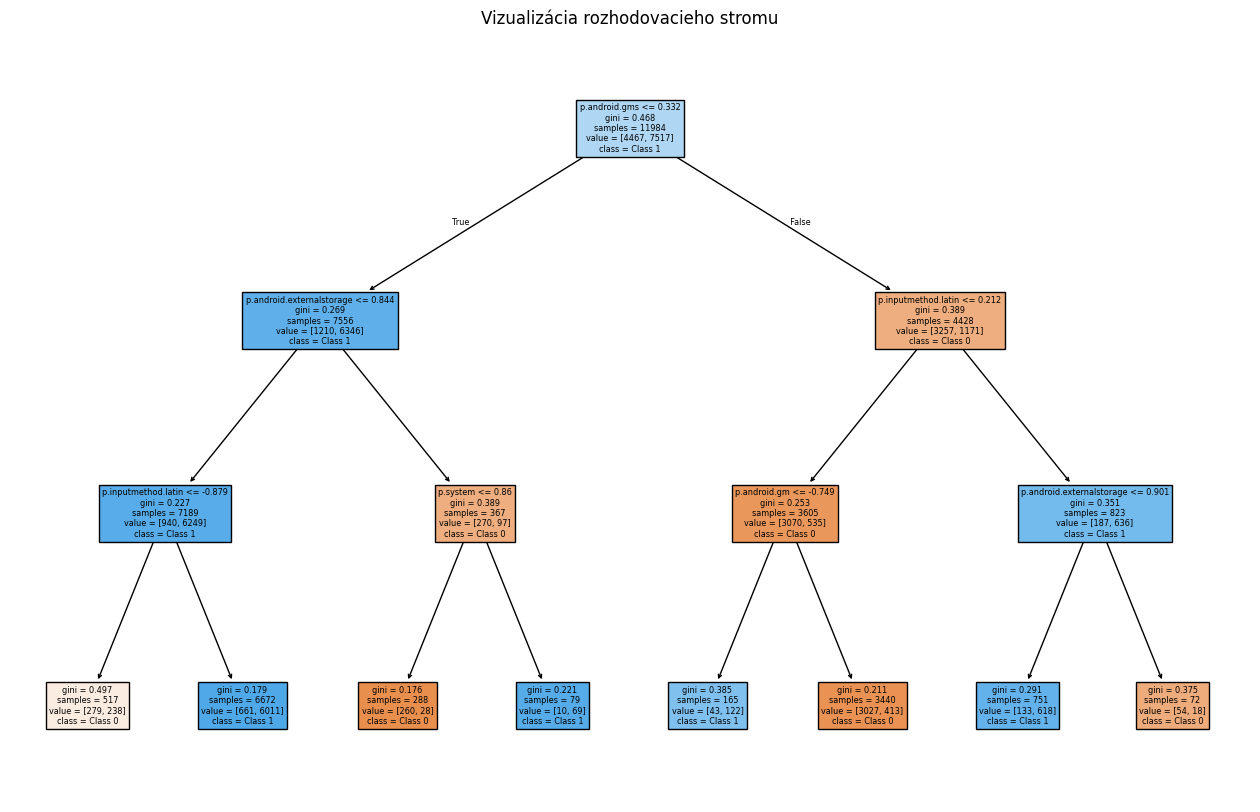

In [81]:
plt.figure(figsize=(16, 10))
plot_tree(dt_model, feature_names=X_train.columns, class_names=['Class 0', 'Class 1'], filled=True)
plt.title("Vizualizácia rozhodovacieho stromu")
plt.show()

### (E)

## Hodnotenie modelov pomocou metrík

### Decision Tree Classifier:
- **Accuracy**: 0.8788 (87.88%)  
- **Precision**: 0.8783  
- **Recall**: 0.8788  

Decision Tree Classifier dosiahol vysokú presnosť a vyvážené hodnoty precision a recall. To naznačuje, že model dokáže spoľahlivo identifikovať väčšinu správnych tried, avšak mierne zaostáva za Logistic Regression, čo sa týka predikčnej presnosti.

---

### Logistic Regression:
- **Accuracy**: 0.8922 (89.22%)  
- **Precision**: 0.8923  
- **Recall**: 0.8922  

Logistic Regression prekonal Decision Tree vo všetkých troch hodnotených metrikách. Dosiahol najlepšiu presnosť, čo naznačuje, že má menej nesprávnych predikcií, pričom vysoké hodnoty precision a recall ukazujú na efektívnu detekciu správnych tried a minimálne chyby.

---

### ID3 Classifier:
- **Accuracy**: 0.8588 (85.88%)
- **Precision**: 0.8599  
- **Recall**: 0.8588  

ID3 Classifier dosiahol vyvážené výsledky so zhodnými hodnotami v metrikách. Tento model vykazuje stabilné výkony pri detekcii tried, ale nie je najvýkonnejší. Model môže mať menší priestor na zlepšenie, najmä vzhľadom na jeho jednoduchosť.

### 3.3 Optimalizácia alias hyperparameter tuning

### (A)

In [82]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

# Definícia priestorov hyperparametrov
param_dist = [
    {
        'C': loguniform(1e-4, 1e4),  # Regularizačná sila
        'penalty': ['l1', 'l2'],  # L1 a L2 penalizácia
        'solver': ['liblinear'],  # Solver podporujúci L1 a L2
        'max_iter': [100, 200, 500]  # Počet iterácií
    },
    {
        'C': loguniform(1e-4, 1e4),
        'penalty': ['elasticnet'],  # ElasticNet penalizácia
        'solver': ['saga'],  # ElasticNet podporuje iba solver saga
        'l1_ratio': [0.1, 0.5, 0.9],  # ElasticNet hyperparameter
        'max_iter': [100, 200, 500]
    }
]

# RandomizedSearchCV na optimalizáciu Logistic Regression
random_search_lr = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Počet náhodných iterácií
    scoring='accuracy',  # Optimalizujeme podľa accuracy
    cv=5,  # 5-násobná krížová validácia
    n_jobs=-1,
    random_state=42
)

random_search_lr.fit(X_train_transformed, y_train)

# Najlepšie hyperparametre a model
best_params_lr = random_search_lr.best_params_
optimized_lr_model = LogisticRegression(random_state=42, **best_params_lr)
optimized_lr_model.fit(X_train_transformed, y_train)

# Predikcie a vyhodnotenie
optimized_lr_predictions = optimized_lr_model.predict(X_test_transformed)

optimized_lr_accuracy = accuracy_score(y_test, optimized_lr_predictions)
optimized_lr_precision = precision_score(y_test, optimized_lr_predictions, average='weighted')
optimized_lr_recall = recall_score(y_test, optimized_lr_predictions, average='weighted')

print("Optimalizované výsledky Logistic Regression (po rozšírenej optimalizácii):")
print(f"Najlepšie hyperparametre: {best_params_lr}")
print(f"Accuracy: {optimized_lr_accuracy:.4f}")
print(f"Precision: {optimized_lr_precision:.4f}")
print(f"Recall: {optimized_lr_recall:.4f}")

Optimalizované výsledky Logistic Regression (po rozšírenej optimalizácii):
Najlepšie hyperparametre: {'C': np.float64(0.034996756820693704), 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.8952
Precision: 0.8952
Recall: 0.8952


In [83]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Definícia priestorov hyperparametrov
param_dist_dt = {
    'max_depth': randint(2, 20),  # Maximálna hĺbka stromu
    'min_samples_split': randint(2, 20),  # Minimálny počet vzoriek na rozdelenie
    'min_samples_leaf': randint(1, 20),  # Minimálny počet vzoriek v liste
    'criterion': ['gini', 'entropy'],  # Kritérium pre výpočet kvality rozdelenia
    'splitter': ['best', 'random']  # Stratégiu delenia uzlov
}

# RandomizedSearchCV na optimalizáciu Decision Tree
random_search_dt = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=50,  # Počet náhodných iterácií
    scoring='accuracy',  # Optimalizujeme podľa accuracy
    cv=5,  # 5-násobná krížová validácia
    n_jobs=-1,
    random_state=42
)

random_search_dt.fit(X_train_transformed, y_train)

# Najlepšie hyperparametre a model
best_params_dt = random_search_dt.best_params_
optimized_dt_model = DecisionTreeClassifier(random_state=42, **best_params_dt)
optimized_dt_model.fit(X_train_transformed, y_train)

# Predikcie a vyhodnotenie
optimized_dt_predictions = optimized_dt_model.predict(X_test_transformed)

optimized_dt_accuracy = accuracy_score(y_test, optimized_dt_predictions)
optimized_dt_precision = precision_score(y_test, optimized_dt_predictions, average='weighted')
optimized_dt_recall = recall_score(y_test, optimized_dt_predictions, average='weighted')

print("Optimalizované výsledky Decision Tree:")
print(f"Najlepšie hyperparametre: {best_params_dt}")
print(f"Accuracy: {optimized_dt_accuracy:.4f}")
print(f"Precision: {optimized_dt_precision:.4f}")
print(f"Recall: {optimized_dt_recall:.4f}")

Optimalizované výsledky Decision Tree:
Najlepšie hyperparametre: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 19, 'min_samples_split': 12, 'splitter': 'best'}
Accuracy: 0.8992
Precision: 0.8989
Recall: 0.8992


### (B)

In [84]:
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Bagging
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=best_params_dt['max_depth'], 
                                      min_samples_split=best_params_dt['min_samples_split'], 
                                      min_samples_leaf=best_params_dt['min_samples_leaf'], 
                                      random_state=42),
    n_estimators=50,  # Počet stromov
    random_state=42
)
bagging_model.fit(X_train_transformed, y_train)
bagging_predictions = bagging_model.predict(X_test_transformed)

bagging_accuracy = accuracy_score(y_test, bagging_predictions)
bagging_precision = precision_score(y_test, bagging_predictions, average='weighted')
bagging_recall = recall_score(y_test, bagging_predictions, average='weighted')

# AdaBoost
adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=best_params_dt['max_depth'], 
                                      min_samples_split=best_params_dt['min_samples_split'], 
                                      min_samples_leaf=best_params_dt['min_samples_leaf'], 
                                      random_state=42),
    n_estimators=50,  # Počet iterácií boostingu
    random_state=42,
    algorithm='SAMME'
)
adaboost_model.fit(X_train_transformed, y_train)
adaboost_predictions = adaboost_model.predict(X_test_transformed)

adaboost_accuracy = accuracy_score(y_test, adaboost_predictions)
adaboost_precision = precision_score(y_test, adaboost_predictions, average='weighted')
adaboost_recall = recall_score(y_test, adaboost_predictions, average='weighted')

# Výsledky
print("Bagging Classifier:")
print(f"Accuracy: {bagging_accuracy:.4f}")
print(f"Precision: {bagging_precision:.4f}")
print(f"Recall: {bagging_recall:.4f}")

print("\nAdaBoost Classifier:")
print(f"Accuracy: {adaboost_accuracy:.4f}")
print(f"Precision: {adaboost_precision:.4f}")
print(f"Recall: {adaboost_recall:.4f}")

Bagging Classifier:
Accuracy: 0.9109
Precision: 0.9108
Recall: 0.9109

AdaBoost Classifier:
Accuracy: 0.9025
Precision: 0.9022
Recall: 0.9025


### (C)

In [85]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score
import numpy as np

optimal_log_reg = LogisticRegression(
    C=best_params_lr['C'],
    solver=best_params_lr['solver'],
    max_iter=1000,
    random_state=42
)

optimal_dt = DecisionTreeClassifier(
    max_depth=best_params_dt['max_depth'],
    min_samples_split=best_params_dt['min_samples_split'],
    min_samples_leaf=best_params_dt['min_samples_leaf'],
    random_state=42
)

logistic_accuracy = cross_val_score(optimal_log_reg, X_train_transformed, y_train, cv=5, scoring='accuracy')
decision_tree_accuracy = cross_val_score(optimal_dt, X_train_transformed, y_train, cv=5, scoring='accuracy')

logistic_precision = cross_val_score(optimal_log_reg, X_train_transformed, y_train, cv=5, scoring='precision_weighted')
decision_tree_precision = cross_val_score(optimal_dt, X_train_transformed, y_train, cv=5, scoring='precision_weighted')

logistic_recall = cross_val_score(optimal_log_reg, X_train_transformed, y_train, cv=5, scoring='recall_weighted')
decision_tree_recall = cross_val_score(optimal_dt, X_train_transformed, y_train, cv=5, scoring='recall_weighted')

print("Krížová validácia pre optimalizovaný Logistic Regression:")
print(f"Accuracy: {logistic_accuracy.mean():.4f} ")
print(f"Precision: {logistic_precision.mean():.4f}")
print(f"Recall: {logistic_recall.mean():.4f}")

print("\nKrížová validácia pre optimalizovaný Decision Tree Classifier:")
print(f"Accuracy: {decision_tree_accuracy.mean():.4f}")
print(f"Precision: {decision_tree_precision.mean():.4f}")
print(f"Recall: {decision_tree_recall.mean():.4f}")

Krížová validácia pre optimalizovaný Logistic Regression:
Accuracy: 0.8915 
Precision: 0.8917
Recall: 0.8915

Krížová validácia pre optimalizovaný Decision Tree Classifier:
Accuracy: 0.8944
Precision: 0.8941
Recall: 0.8944


### (D)

Decision Tree - Trénovacia Accuracy: 0.9043
Decision Tree - Testovacia Accuracy: 0.8992
Decision Tree - Trénovacia Precision: 0.9052
Decision Tree - Testovacia Precision: 0.9031
Decision Tree - Trénovacia Recall: 0.9465
Decision Tree - Testovacia Recall: 0.9389


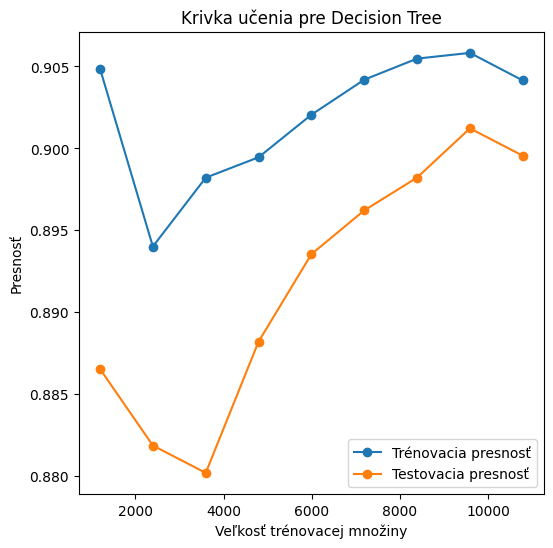

Model neprejavuje overfitting pri veľkosti trénovacej množiny 1198.
Trénovacia presnosť: 0.9048, Testovacia presnosť: 0.8865
Model neprejavuje overfitting pri veľkosti trénovacej množiny 2396.
Trénovacia presnosť: 0.8940, Testovacia presnosť: 0.8818
Model neprejavuje overfitting pri veľkosti trénovacej množiny 3595.
Trénovacia presnosť: 0.8982, Testovacia presnosť: 0.8802
Model neprejavuje overfitting pri veľkosti trénovacej množiny 4793.
Trénovacia presnosť: 0.8994, Testovacia presnosť: 0.8882
Model neprejavuje overfitting pri veľkosti trénovacej množiny 5992.
Trénovacia presnosť: 0.9020, Testovacia presnosť: 0.8935
Model neprejavuje overfitting pri veľkosti trénovacej množiny 7190.
Trénovacia presnosť: 0.9042, Testovacia presnosť: 0.8962
Model neprejavuje overfitting pri veľkosti trénovacej množiny 8388.
Trénovacia presnosť: 0.9055, Testovacia presnosť: 0.8982
Model neprejavuje overfitting pri veľkosti trénovacej množiny 9587.
Trénovacia presnosť: 0.9058, Testovacia presnosť: 0.9012


In [86]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Optimalizovaný Decision Tree model
dt_model = DecisionTreeClassifier(max_depth=best_params_dt['max_depth'],
                                  min_samples_split=best_params_dt['min_samples_split'],
                                  min_samples_leaf=best_params_dt['min_samples_leaf'],
                                  random_state=42)

# Fit na tréningových dátach
dt_model.fit(X_train_transformed, y_train)

# Predikcie na trénovacej a testovacej množine
dt_train_pred = dt_model.predict(X_train_transformed)
dt_test_pred = dt_model.predict(X_test_transformed)

# Výkon na trénovacej a testovacej množine
dt_train_acc = accuracy_score(y_train, dt_train_pred)
dt_test_acc = accuracy_score(y_test, dt_test_pred)

# Skontrolujeme aj Precision a Recall
dt_train_precision = precision_score(y_train, dt_train_pred)
dt_test_precision = precision_score(y_test, dt_test_pred)

dt_train_recall = recall_score(y_train, dt_train_pred)
dt_test_recall = recall_score(y_test, dt_test_pred)

print(f"Decision Tree - Trénovacia Accuracy: {dt_train_acc:.4f}")
print(f"Decision Tree - Testovacia Accuracy: {dt_test_acc:.4f}")
print(f"Decision Tree - Trénovacia Precision: {dt_train_precision:.4f}")
print(f"Decision Tree - Testovacia Precision: {dt_test_precision:.4f}")
print(f"Decision Tree - Trénovacia Recall: {dt_train_recall:.4f}")
print(f"Decision Tree - Testovacia Recall: {dt_test_recall:.4f}")

# Zobrazenie krivky učenia pre Decision Tree
train_sizes = [int(len(X_train_transformed) * 0.1 * i) for i in range(1, 10)]

dt_train_scores = []
dt_test_scores = []

# Pre rôzne veľkosti trénovacích množín
for train_size in train_sizes:
    X_train_sub, _, y_train_sub, _ = train_test_split(X_train_transformed, y_train, train_size=train_size, random_state=42)
    
    # Decision Tree
    dt_model.fit(X_train_sub, y_train_sub)
    dt_train_scores.append(dt_model.score(X_train_sub, y_train_sub))
    dt_test_scores.append(dt_model.score(X_test_transformed, y_test))

# Zobrazenie krivky učenia pre Decision Tree
plt.figure(figsize=(6, 6))
plt.plot(train_sizes, dt_train_scores, label="Trénovacia presnosť", marker='o')
plt.plot(train_sizes, dt_test_scores, label="Testovacia presnosť", marker='o')
plt.title("Krivka učenia pre Decision Tree")
plt.xlabel("Veľkosť trénovacej množiny")
plt.ylabel("Presnosť")
plt.legend()
plt.show()

# Funkcia na kontrolu overfittingu
def check_overfitting(train_sizes, train_accuracies, test_accuracies):
    for i in range(len(train_sizes)):
        train_accuracy = train_accuracies[i]
        test_accuracy = test_accuracies[i]
        
        # Ak je rozdiel medzi trénovacou a testovacou presnosťou veľký, model môže trpieť overfittingom
        if train_accuracy - test_accuracy > 0.05:  # Zohľadňujeme rozumnú hranicu rozdielu
            print(f"Varovanie: Model môže trpieť overfittingom pri veľkosti trénovacej množiny {train_sizes[i]}!")
            print(f"Trénovacia presnosť: {train_accuracy:.4f}, Testovacia presnosť: {test_accuracy:.4f}")
        else:
            print(f"Model neprejavuje overfitting pri veľkosti trénovacej množiny {train_sizes[i]}.")
            print(f"Trénovacia presnosť: {train_accuracy:.4f}, Testovacia presnosť: {test_accuracy:.4f}")

# Overenie na overfitting
check_overfitting(train_sizes, dt_train_scores, dt_test_scores)

### 3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

### (A)

### (B)

### (C)

### (D)

### (E)